In [1]:
import numpy as np
import random 
import matplotlib.pyplot as plt 
import camb
import constnumberfile as cn
from camb import model, initialpower
from scipy import signal, interpolate, integrate
import copy

In [2]:
#make the power spectrum
pars = camb.CAMBparams()
pars.set_cosmology(H0=70.4, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=0);
pars.set_matter_power(redshifts=np.linspace(0,10,101), kmax=1e2)

#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1e2, npoints = 100)
s8 = np.array(results.get_sigma8())
#print(results.get_sigma8())

Note: redshifts have been re-sorted (earliest first)


In [3]:
#make the interpolation (ndpk is nondimensional power spectrum.)
ndpk=pk*(kh[None,:]**3/(2*np.pi**2))
f2 = interpolate.interp2d(kh,z, ndpk)
#define the power spectrum function
def PSz(kin,zin):
    matterpower=f2(kin,zin)
    return matterpower

In [4]:
#make the function which calculate the tophat window function assigned the sphere area of structure formation
def tophat(M):
    k=np.logspace(-4,2,500)
    R=(3*M*cn.mo/(4*np.pi*cn.om*cn.rc0))**(1/3)/cn.Mpc
    kR=k[None,:]*R[:,None]
    topwin=3*(np.sin(kR)-kR*np.cos(kR))/(kR)**3
    return topwin,k

#make the function which calculates the mass variance square S(M)
def varips(M,z):
    topwin,k=tophat(M)
    #print(PSz(k,z).shape,topwin.shape,k.shape)
    dvari=PSz(k,z)[None,:]*topwin**2/k[None,:]
    #print(dvari.shape)
    SM=integrate.simps(dvari,k[None,:],axis=1)
    #diffSM=np.diff(SM)/np.diff(M)
    return SM

#make the function which calculates the mass variance S(M) 
# assign M[Msolar] , z(redshift)[nondim]
def varipsapproximate(M,z):
    M8=4/3 * np.pi * cn.om * cn.rc0MMpc * 8**3
    #alpha=(cn.ns+3)/3
    alpha=0.333
    SM=cn.sigma8**2*(M/M8)**(-alpha)
    #print(np.log10(M8))
    return SM/(1+z)**2
def varipsapproximatediffM(M,z):
    M8=4/3 * np.pi * cn.om * cn.rc0MMpc * 8**3
    alpha=(cn.ns+3)/3
    alpha=0.333
    SM=cn.sigma8**2*(M/M8)**(-alpha)
    diffdSdM=alpha/M * SM
    return diffdSdM/(1+z)**2

def z_to_t(z):
    t=2/(3*cn.H0*np.sqrt(cn.om))*(1+z)**(-3/2)
    return t

In [5]:
def ffu(z0,z1,M0,M1):
    deltac=1.686
    #introduce the mass variance square
    vari0=varipsapproximate(M0,z0)
    vari1=varipsapproximate(M1,z1)
    coefficientterm=deltac*(z1-z0)/(np.sqrt(2*np.pi)*(abs(vari1-vari0))**(1.5))
    expterm=np.exp(-(deltac*(z1-z0))**2/(2*(vari1-vari0)))
    ffuterm=coefficientterm*expterm
    return ffuterm

In [6]:
#M1=np.logspace(10,13,1000)
#plt.loglog(M1,ffu(0,1,1e15,M1))
#print(integrate.simps(ffu(0,1,1e15,M1)))

# Galaxy
## section
### sub

\begin{equation}
\frac{dP}{dM}= \frac{M_0}{M_1}
\end{equation}

\begin{equation}
sigma^2(M,z)
\end{equation}
\begin{equation}
\frac{dS}{dM} as a function of M
\end{equation}
\begin{equation}
dP/dM_1(z0,z1,M0,M1)
\end{equation}
\begin{equation}
\int dP/dM_1 dM_1 = 1.0
\end{equation}

# Galaxy Formation Section 7.3.4 Halo Assembly and Formation time

equation (7.83)
\begin{equation}
\frac{dP}{dM_1}(<t_a|M_0 , t_0)dM_1=\frac{M_0}{M_1}f_{FU}(S_1 , \delta_1 | S_0 , \delta_0) \left|\frac{dS_1}{dM_1} \right|dM_1,
\end{equation}
Here, 
\begin{equation}
f_{FU}(S_1 , \delta_1 | S_0 , \delta_0)dS_1=\frac{1}{\sqrt{2 \pi}} \frac{\delta_1 -\delta_0}{(S_1-S_0)^{3/2}}
\exp \left[-\frac{(\delta_1-\delta_0)^2}{2(S_1 - S_0)} \right]dS_1.
\end{equation}


About $f_{FU}(S_1 , \delta_1 | S_0 , \delta_0)$, using $\delta_1 =\delta_c z_1$ and $\delta_0 = \delta_c z_0$ ,
we is given by


\begin{equation}
f_{FU}(S_1 , \delta_1 | S_0 , \delta_0)dS_1=\frac{\delta_c}{\sqrt{2 \pi}} \frac{z_1 -z_0}{(S_1-S_0)^{3/2}}
\exp \left[-\frac{\delta_c^2(z_1-z_0)^2}{2(S_1 - S_0)} \right]dS_1,
\end{equation}
where the criteria for collapse $\delta_c=1.686$.

# memo
\begin{equation}
\left|\frac{dS(M)}{dM} \right|=\frac{\alpha}{M} S(M)
\end{equation}

In [34]:
#make the function which calculate the f_{FU}.
# z0:parent halo redshift M0: parent halo mass
# z1:progenitor halo redshift M1:main progenitor halo mass
def ffu(z0,z1,M0,M1):
    deltac=1.686
    #introduce the mass variance square
    vari0=varipsapproximate(M0,z0)
    vari1=varipsapproximate(M1,z1)
    #vari0=varips(M0,z0)
    #vari1=varips(M1,z1)
    # calculate ffu
    coefficientterm=deltac*(z1-z0)/(np.sqrt(2*np.pi)*(abs(vari1-vari0))**(1.5))
    expterm=np.exp(-(deltac*(z1-z0))**2/(2*(vari1-vari0)))
    ffuterm=coefficientterm*expterm
    #print(coefficientterm,expterm)
    return ffuterm#,coefficientterm,expterm,ffuterm
#Under the t=t_0 and M=M_0, the probability on M=M_1.
#make the function which calculate the dP/dM_1.
def dpdm1(z0,z1,M0,M1):
    #calculate the diffrential term (accuracy level 0.001)
    #D=M1*1e-10
    #diffdSdM=abs(varips(M1-D,z1)-varips(M1,z1))/D
    diffdSdM=varipsapproximatediffM(M1,z1)
    dpdm= ffu(z0,z1,M0,M1) * diffdSdM
    #print(ffu(z0,z1,M0,M1),diffdSdM)
    return dpdm

In [35]:
def Mmax(z0,z1,M0):
    Mmax=((1+z1)/(1+z0))**(-6)*M0
    return Mmax

(10000000000000.0, 100000000000000.0)

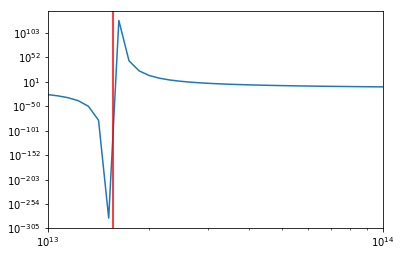

In [36]:
M0=1e15
#M1=np.logspace(np.log10(M0*(((1+2)/(1+0))**(-2/0.333))),np.log10(M0),100)
M1=np.logspace(np.log10(1e12),np.log10(M0),100)
#M0=1e13
#plt.loglog(M1,integrate.cumtrapz(dpdm1(0,1,M0,M1),M1))
#plt.loglog(M1,ffu(0,1,M0,M1))
plt.loglog(M1,dpdm1(0,1,M0,M1))
plt.axvline(x=Mmax(0,1,1e15),color='red')
plt.xlim(1e13,1e14)
#plt.semilogx(M1,ffu(0,0.2,M0,M1)[1])
#plt.semilogx(M1,ffu(0,0.2,M0,M1)[2])
#plt.semilogx(M1[0:-1],integrate.cumtrapz(ffu(0,0.2,M0,M1),M1))

In [70]:
#under the probability of EPS formalism, generateing the random mass numbers.
#Please assign the mass binnumber.
def EPSrandommass(z0,z1,M0,binnumber):
    #Main proginitor need to be bigger than any other halo mass.
    #Therefore, M_p > M_0/2
    Ms=((1+z1)/(1+z0))**(-2/0.33)*M0
    #print(Ms)
    #M1=np.linspace(1e10,Ms[0],binnumber)
    M1=np.logspace(np.log10(Ms/8),np.log10(Ms),binnumber)
    #M1=np.linspace(Ms/2,Ms,binnumber)
    #M1=np.logspace(np.log10(1e13),np.log10(Ms[0]),binnumber)
    #set the probability function
    dpdm=dpdm1(z0,z1,M0,M1)
    #generate the EPSrandommass
    Mg=random.choices(M1, weights=dpdm)
    return Mg

In [71]:
print(EPSrandommass(0,0.08,1e15,100),EPSrandommass(0,0.08,1e15,100))

[487490696638989.94] [477358006170520.5]


In [72]:
M0=np.zeros(10000)
print(M0.shape)
for i,M00 in enumerate(M0):
    M0[i]=EPSrandommass(0,0.02,0.45e8,100)[0]

(10000,)


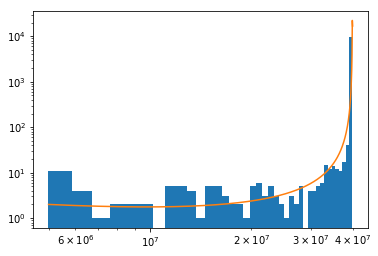

In [76]:
plt.hist(M0,log=True,bins=40)
plt.xscale('log')
M1=np.logspace(np.log10(5*1e6),np.log10(4*1e7),1000)
plt.loglog(M1,dpdm1(0,0.02,np.array([0.45e8]),M1)*1e10)

In [77]:
def mergertree(Minitial,Mmin,zstart,zlast,dw):
    #define the time interval
    deltac=1.686
    #tstart=z_to_t(zstart)
    #tlast=z_to_t(zlast)
    #print(tstart,tlast)
    numbinz = int((deltac/dw)*(zlast-zstart))
    #numbint = int((deltac/dw)*(tstart-tlast))
    z=np.linspace(zstart,zlast,numbinz)
    #t=np.linspace(tlast,tstart,numbint)
    Mleft=Minitial
    Np=0
    #Mp=Mleft * random.random()
    #make the array
    Mplist=np.array(Minitial)
    zlist=np.array(z[0])
    #tlist=np.array(t[0])
    #assign the mass under the probability of EPS.
    Mp=EPSrandommass(z[0],z[1],Mleft,100)[0]
    #Mp=EPSrandommass(t[0],t[1],Mleft,100)[0]
    while (max(Mleft,Mp) >= Mmin):
    #for Np in range(len(z)-1):
        #Mleft=np.random.choice([Mleft,Mp])
        Mleft=max([Mleft,Mp])
        Mp= EPSrandommass(z[Np],z[Np+1],Mleft,100)[0]
        #Mp= EPSrandommass(t[Np],t[Np+1],Mleft,100)[0]
        Mleft=Mleft-Mp
        #print("Mp:%e,Mleft:%e"%(Mp,Mleft))
        Mplist=np.append(Mplist,Mp)
        zlist=np.append(zlist,z[Np+1])
        #tlist=np.append(tlist,z[Np+1])
        if (max(Mp,Mleft) > Mmin):
            if (min(Mp,Mleft)>Mmin):
                Np = Np + 1
                #print(Np)
                continue
            continue
        else:
            #print("last result Mp:%f,Mleft:%f"%(Mp,Mleft))
            Mleft=max(Mp,Mleft)
            break
    #print("z:%d"%len(z))
    return Np+1,Mleft,Mp,Mplist,zlist

In [78]:
Npr,Mplast,Macc,Mplist,zlist=mergertree(5*1e12,1e10,0,1,0.02)
print("Npr:%d,Mplast:%e,Macc:%e"%(Npr,Mplast,Macc))
Mleft=Mplast+Macc
print("lastMleft:%e"%Mleft)

Npr:56,Mplast:9.623843e+09,Macc:9.623843e+09
lastMleft:1.924769e+10


In [79]:
#zlist

In [82]:
for i in range(10):
    exec("Npr%s,Mplast%s,Macc%s,Mplist%s,zlist%s=mergertree(5*1e12,1e10,0,1,0.02)"%(i,i,i,i,i))

Text(0, 0.5, '$M / M_0$')

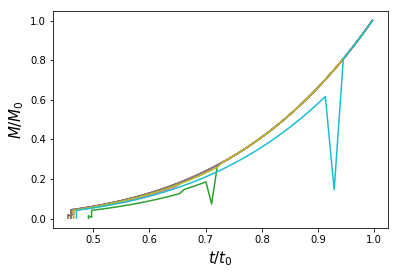

In [83]:
for i in range(10):
    #exec("t%s=np.linspace(1,(1.0-(len(Mplist%s)/168600)),len(Mplist%s))"%(i,i,i))
    exec("plt.plot(2/(3*cn.H0*np.sqrt(cn.om))*(1+zlist%s)**(-3/2)/(5.5*1e17),Mplist%s/(5*1e12))"%(i,i))
#plt.plot(Mplist1/1e15)
#plt.plot(Mplist2/1e15)
#plt.plot(Mplist3/1e15)
#plt.plot(Mplist4/1e15)
plt.xlabel(r'$t / t_0$',size=15)
plt.ylabel(r'$M / M_0$',size=15)
#plt.xlim(0.95,1)